# Human Resources Analysis
This dataset is built off of a kaggle dataset containing various measures from a human resources organization. Measures include: the satisfaction level of the employee measured on a 0.0-1.0 scale; the most recent evaluation of the employee, measured on the same scale; the number of projects the employee is currently working on; the average number of hours the employee has worked; the number of years spent with the employer; whether the employee has had an accident while at work; whether the employee has left; if the employee has received a promotion within the last five years; the department where the employee worked, and; the salary level of the employee as defined by HR. 

This notebook attempts a number of new algorithms for classification. The goal is to see if we can determine whether or not an employee will leave, and under what circumstances they may leave. I follow the normal data analysis process: data retrieval, data cleaning, exploration, feature extraction, and classification.

In [1]:
import pandas as pd

df = pd.read_csv('D:\\Documents\\Research\\Datasets\\HR.csv')

df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [2]:
print(df.info())
print('\n')
print(df.isnull().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None


satisfaction_level       False
last_evaluation          False
number_project           False
average_montly_hours     False
time_spend_company       False
Work_accident            False
left                     False
promotion_last_5years    False
sales                    False
salary                   False
dtype: bool


In the normal process I checked for null values, but the dataset is already clean. But, fascinatingly, the dataset apparently contains a vast number of duplicates, demonstrated below as the matrix decreases from a 14999x10 one to a 11991x10 one.

In [3]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11991 entries, 0 to 11999
Data columns (total 10 columns):
satisfaction_level       11991 non-null float64
last_evaluation          11991 non-null float64
number_project           11991 non-null int64
average_montly_hours     11991 non-null int64
time_spend_company       11991 non-null int64
Work_accident            11991 non-null int64
left                     11991 non-null int64
promotion_last_5years    11991 non-null int64
sales                    11991 non-null object
salary                   11991 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.0+ MB


#### This shows that we have a turnover rate of around 17%. Doesn't seem too particularly high.

In [4]:
df.left.value_counts() / len(df)

0    0.833959
1    0.166041
Name: left, dtype: float64

#### Here we see the mean values for the various measures associated with whether the employee left or not. Some things stand out: the satisfaction level of those that stayed is 22% higher than those that left.

In [5]:
df.groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.667365,0.715667,3.786800,198.94270,3.262000,0.174500,0.019500
1,0.440271,0.721783,3.883476,208.16223,3.881467,0.052737,0.004018


## Exploratory Analysis
Here we have our first visualizations of the dataset. We can see right off the bat that a significant number of employees left in years 3-5, and employees in the low and medium salary range left, and employees without much work -- who had only two projects as compared to the normal 3-5 -- left moreso than stayed. As we'll see below, other factors such as work accidents, promotions, and department were not factors that differentiated leavers from stayers.

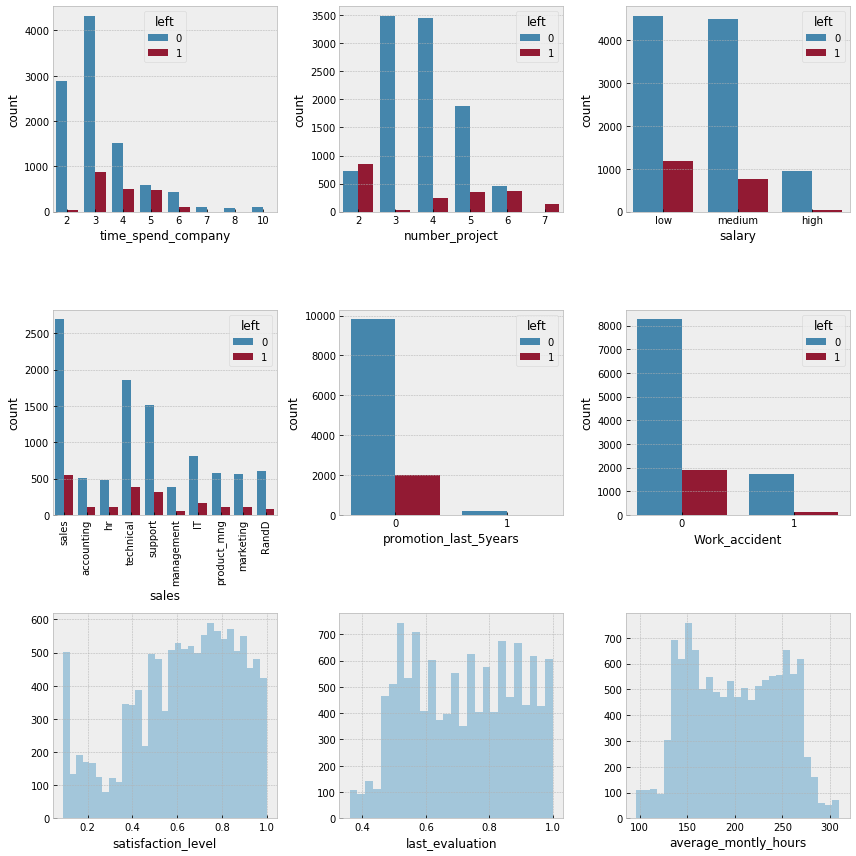

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

f, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
sns.countplot(x='time_spend_company', data=df, hue='left', ax=ax[0,0])
sns.countplot(x='number_project', data=df, hue='left', ax=ax[0,1])
sns.countplot(x='salary', data=df, hue='left', ax=ax[0,2])
sns.countplot(df.sales, hue=df.left, ax=ax[1,0])
sns.countplot(df.promotion_last_5years, hue=df.left, ax=ax[1,1])
sns.countplot(df.Work_accident, hue=df.left, ax=ax[1,2])
sns.distplot(df.satisfaction_level, kde=False, ax=ax[2,0])
sns.distplot(df.last_evaluation, kde=False, ax=ax[2,1])
sns.distplot(df.average_montly_hours, kde=False, ax=ax[2,2])

ax[1,0].tick_params(axis='x', rotation=90)
plt.tight_layout()

Here is a correlation chart that we can use as a guide moving forward. We can see that, for those that left, satisfaction level and time spent with the company were significant factors. However, a number of other factors were also highly correlated, such as the number of projects an employee worked and their average monthly hours, as well as last evaluation.

In [7]:
df.corr()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
satisfaction_level,1.000000,0.095186,-0.133246,-0.006252,-0.152915,0.039940,-0.350558,0.019789
last_evaluation,0.095186,1.000000,0.270256,0.264678,0.096829,-0.005695,0.013520,-0.007206
number_project,-0.133246,0.270256,1.000000,0.331516,0.188837,-0.005612,0.030928,-0.000544
average_montly_hours,-0.006252,0.264678,0.331516,1.000000,0.102875,-0.012860,0.070409,-0.004964
time_spend_company,-0.152915,0.096829,0.188837,0.102875,1.000000,0.000003,0.173295,0.056828
Work_accident,0.039940,-0.005695,-0.005612,-0.012860,0.000003,1.000000,-0.125436,0.029852
left,-0.350558,0.013520,0.030928,0.070409,0.173295,-0.125436,1.000000,-0.044657
promotion_last_5years,0.019789,-0.007206,-0.000544,-0.004964,0.056828,0.029852,-0.044657,1.000000


Here is some demonstration. We can see right from the first row that the number of projects worked, when measured against an employee's last evaluation, their average hours, and satisfaction level, shows a disproportionate number of high-achievers leaving and low total hours leaving. When an employee only has 2 projects, those that leave have lower evaluations, lower hours, and lower satisfaction level. When employees have 4 or more projects, those that leave have higher evaluations, higher hours, and higher satisfaction levels until reaching projects 6 and 7 at which point they on average have significantly lower satisfaction levels. Furthermore, this is consistent across departments and salary levels, although the 'low' and 'medium' salary levels are more affected by satisfaction levels than the 'higher' categorization.

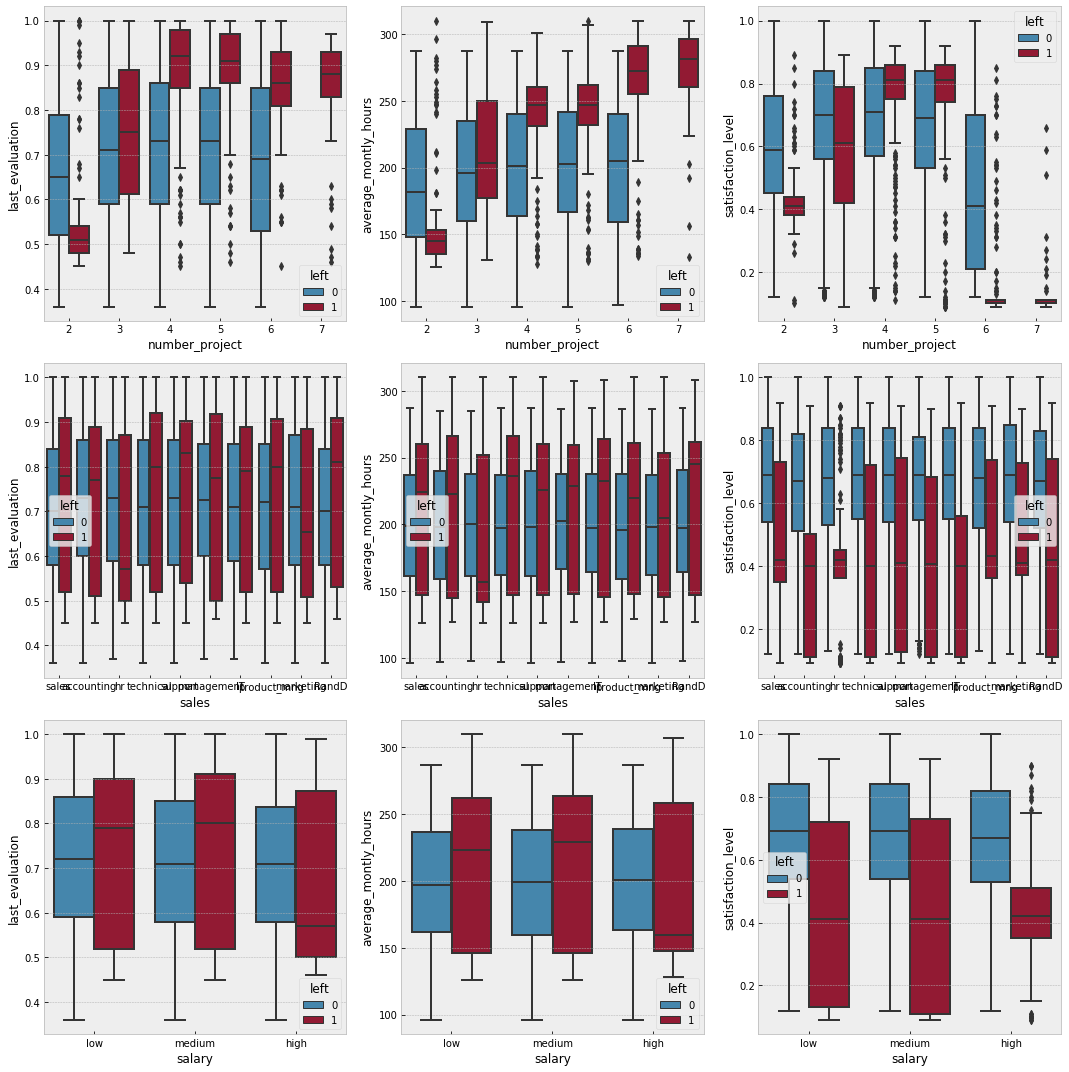

In [8]:
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
sns.boxplot(df.number_project, df.last_evaluation, hue=df.left, ax=ax[0,0])
sns.boxplot(df.number_project, df.average_montly_hours, hue=df.left, ax=ax[0,1])
sns.boxplot(df.number_project, df.satisfaction_level, hue=df.left, ax=ax[0,2])
sns.boxplot(df.sales, df.last_evaluation, hue=df.left, ax=ax[1,0])
sns.boxplot(df.sales, df.average_montly_hours, hue=df.left, ax=ax[1,1])
sns.boxplot(df.sales, df.satisfaction_level, hue=df.left, ax=ax[1,2])
sns.boxplot(df.salary, df.last_evaluation, hue=df.left, ax=ax[2,0])
sns.boxplot(df.salary, df.average_montly_hours, hue=df.left, ax=ax[2,1])
sns.boxplot(df.salary, df.satisfaction_level, hue=df.left, ax=ax[2,2])
plt.tight_layout()

In the two charts below we can see three groups of leavers that correspond almost directly 1-to-1. They are as follows: hard-workers with high evaluations but high numbers of hours; hard-workers that work an above average number of hours (the average from the above means chart is ~200 monthly hours) and are nonetheless satisfactory, and; employees with far below average hours and below average evaluations who are also unhappy.

These three groups could be described as thus: burnouts, hard-workers leaving for potentially higher pay, and workers without actual work. I run a quick KMeans test to see if the algorithm picks up on these groups, which it does.

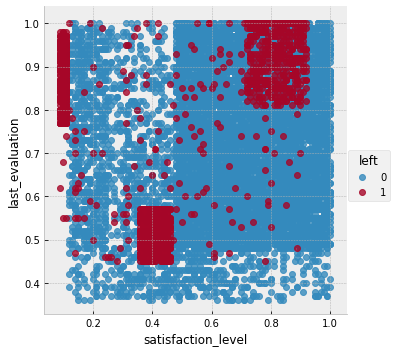

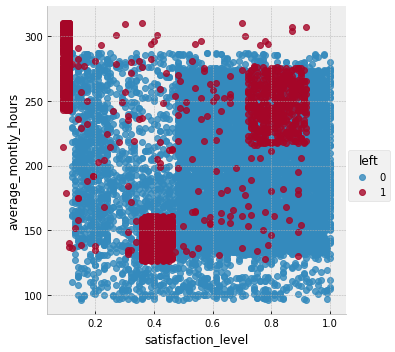

In [9]:
sns.lmplot(x='satisfaction_level', y='last_evaluation', hue='left', data=df, fit_reg=False)
sns.lmplot(x='satisfaction_level', y='average_montly_hours', hue='left', data=df, fit_reg=False)

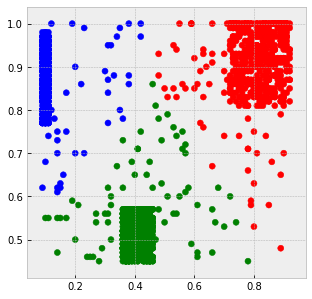

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(df[df.left == 1][['satisfaction_level','last_evaluation']])

colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]

plt.figure(figsize=(5,5))
plt.scatter(x='satisfaction_level',y='last_evaluation',data=df[df.left == 1], color=colors)

## Machine Learning
From here on is the meat of our machine learning algorithms. First, we do some quick feature extraction to find the best correlations between the measures and our target: number of projects, average hours worked, satisfaction level, evaluations, and time with the company. Using these measures we run some quick and dirty scikit-learn algorithms: a basic linear model logistic regression that has around 83% accuracy, a decision tree classifier with around 96% accuracy, and a random forest classifier with around 98% accuracy.

([<matplotlib.axis.XTick at 0x1f047072cc0>,
 <a list of 9 Text xticklabel objects>)

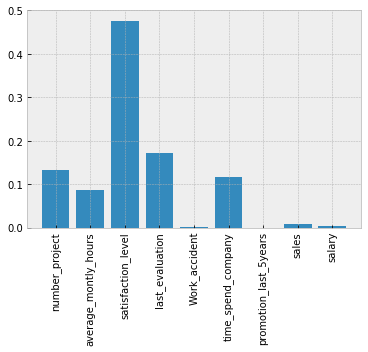

In [11]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

model = df.copy()
model.sales = model.sales.astype('category').cat.codes
model.salary = model.salary.astype('category').cat.codes

X = model.drop('left', axis=1)
y = model.left

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

tree = DecisionTreeClassifier()
tree = tree.fit(X_train, y_train)

indices = np.argsort(tree.feature_importances_[::-1])
names = X.columns
plt.bar(range(len(indices)), tree.feature_importances_[indices])
plt.xticks(range(len(indices)), names[indices], rotation='vertical')

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score

features = ['satisfaction_level','number_project','average_montly_hours','last_evaluation','time_spend_company']
X = X[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

regr = LogisticRegression(penalty='l2', C=1)
regr.fit(X_train, y_train)
accuracy_score(y_test, regr.predict(X_test))

0.83501768569984836

In [13]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(class_weight='balanced',min_weight_fraction_leaf=0.01)
tree = tree.fit(X_train, y_train)
accuracy_score(y_test, tree.predict(X_test))

0.96841839312784239

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=10, class_weight='balanced')
rf.fit(X_train, y_train)
accuracy_score(y_test, rf.predict(X_test))

0.98458817584638703

## Conclusion

Although the random forest classifier has the best record here, our feature extractions and exploration helps explain what is happening under the hood. Employees that leave are falling into three extreme groups that are far outside the average for the total workforce. Workers are burning out; some are not receiving enough work and are thus likely falling into a vicious cycle of low-work -> low-satisfaction -> low-evaluations; and some are very happy and work hard but aren't burning themselves out and likely leaving for higher pay after being recognized for their accomplishments and work. The third category is a good thing: turnover for good work and happy employees reflects well on the company, and likely a result of myriad features not measured such as a desire to do something different, wanting higher pay, and etc. The other two not so much, and more than likely reflect on their specific managers, or maybe just their personality not fitting with the company.